# AethraDB All Query Result Analysis Overview
This file contains the result analysis for the filter query aggregation and join queries at the current stage of development in the AethraDB engine. Additionally, it contains a comparison against a single-threaded run of the same queries on the same data on DuckDB version 0.8.1 using PyArrow 13.0.0.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('tableau-colorblind10')
plt_patterns = ('-', 'x','/','\\','O','o','//','\\\\')

In [2]:
# Load the data from AethraDB
aethra_results_full = pd.read_csv("./jmh-result-R440.csv", dtype = {
    'Benchmark': str,
    'Mode': str,
    'Threads': int,
    'Samples': int,
    'Score': float,
    'Score Error (99.9%)': float,
    'Unit': str,
    'Param: tableFilePath': str,
    'Param: tpchInstance': str
})

# Discard all non-aggregated results
aethra_results = aethra_results_full[~aethra_results_full['Benchmark'].str.contains('executeFilterQuery:executeFilterQuery')]
aethra_results = aethra_results[~aethra_results['Benchmark'].str.contains('executeQuery:executeQuery')].copy(deep=True)

# Round the running-times to 1 decimal
aethra_results["Running-Time"] = aethra_results["Score"].round(1)

# Introduce the scale-factor column
aethra_results["Scale-Factor"] = aethra_results.apply(
    lambda x: 20 if 'sf20' in str(x['Param: tableFilePath']) or 'sf-20' in str(x['Param: tpchInstance'])
        else (10 if 'sf10' in str(x['Param: tableFilePath']) or 'sf-10' in str(x['Param: tpchInstance'])
             else 1), axis=1)

# Discard useless columns
aethra_results.drop(columns=["Mode", "Threads", "Samples", "Score", "Score Error (99.9%)", "Unit"], inplace=True)

aethra_results.head()

,Benchmark,Param: tableFilePath,Param: tpchInstance,Running-Time,Scale-Factor
0,benchmarks.aggregation_query.NonVectorisedNonS...,/nvtmp/AethraTestData/aggregation_query_int/ar...,NaN,371.1,1
9,benchmarks.aggregation_query.NonVectorisedNonS...,/nvtmp/AethraTestData/aggregation_query_int/ar...,NaN,539.1,1
18,benchmarks.aggregation_query.NonVectorisedNonS...,/nvtmp/AethraTestData/aggregation_query_int/ar...,NaN,741.1,1
27,benchmarks.aggregation_query.NonVectorisedNonS...,/nvtmp/AethraTestData/aggregation_query_int/ar...,NaN,2087.7,1
36,benchmarks.aggregation_query.NonVectorisedNonS...,/nvtmp/AethraTestData/aggregation_query_int/ar...,NaN,4915.7,1


# Analysis of the Filter Query at different Scale Factors

In [3]:
# Get the data of the filter query
filter_query = aethra_results[aethra_results['Benchmark'].str.contains('filter_query')].copy(deep=True)

# Introduce the "Engine" column
filter_query["Engine"] = filter_query.apply(
    lambda x: "NV-NS" if 'NonVectorisedNonSimd' in x['Benchmark']
    else ("NV-S" if 'NonVectorisedSimd' in x['Benchmark']
          else ("V-NS" if 'VectorisedNonSimd' in x['Benchmark']
                else "V-S")), axis=1)

# Extract the restrictive column
filter_query["Restrictive-Column"] = filter_query.apply(lambda x: 1 if 'col1_002' in x['Param: tableFilePath'] else (2 if 'col2_002' in x['Param: tableFilePath'] else 3), axis=1)

# Drop irrelevant columns
filter_query.drop(columns=["Benchmark", "Param: tableFilePath", "Param: tpchInstance"], inplace=True)

filter_query.head()

,Running-Time,Scale-Factor,Engine,Restrictive-Column
270,77.0,1,NV-NS,1
279,76.7,1,NV-NS,2
288,78.1,1,NV-NS,3
297,757.6,10,NV-NS,1
306,754.6,10,NV-NS,2


In [4]:
# Load duckdb reference data
filter_query_duck = pd.read_csv("duckdb_filter_query_result_R440.csv")
filter_query_duck.head()

,Running-Time,Scale-Factor,Engine,Restrictive-Column
0,87.7,1,DuckDB,1
1,87.4,1,DuckDB,2
2,87.1,1,DuckDB,3
3,883.8,10,DuckDB,1
4,889.5,10,DuckDB,2


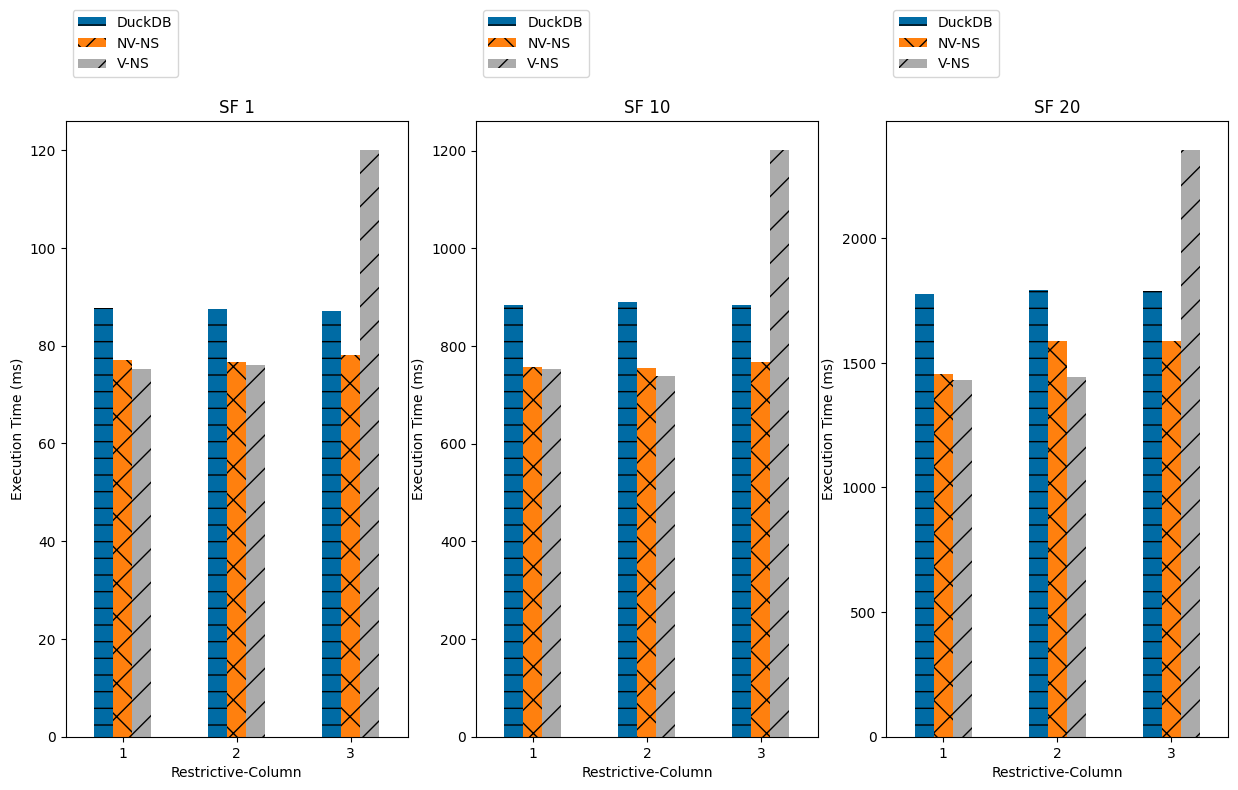

In [5]:
index_column = "Restrictive-Column"
scale_factors = [1, 10, 20]

fig, ax = plt.subplots(nrows=1, ncols=len(scale_factors), figsize=(15,8))

for i, sf in enumerate(scale_factors):
    duckdb_data = filter_query_duck[filter_query_duck["Scale-Factor"] == sf].sort_values(index_column)
    index = duckdb_data[index_column]

    aethra_data = filter_query[filter_query["Scale-Factor"] == sf].sort_values(index_column)
    aethra_nv_ns_data = aethra_data[aethra_data["Engine"] == "NV-NS"]
    aethra_v_ns_data = aethra_data[aethra_data["Engine"] == "V-NS"]

    df = pd.DataFrame({
        'DuckDB': duckdb_data["Running-Time"].tolist(),
        'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
        'V-NS': aethra_v_ns_data["Running-Time"].tolist(),
    }, index = index)

    df.plot.bar(rot=0, ax=ax[i])
    ax[i].set_ylabel("Execution Time (ms)")
    ax[i].set_title("SF " + str(sf))

    bars = ax[i].patches
    hatches = [p for p in plt_patterns for j in range(len(df))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    ax[i].legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

# Analysis of the Aggregation Query at different Scale Factors

In [6]:
# Get the data of the aggregation query
aggregation_query = aethra_results[aethra_results['Benchmark'].str.contains('aggregation_query')].copy(deep=True)

# Introduce the "Engine" column
aggregation_query["Engine"] = aggregation_query.apply(
    lambda x: "NV-NS" if 'NonVectorisedNonSimd' in x['Benchmark']
    else ("NV-S" if 'NonVectorisedSimd' in x['Benchmark']
          else ("V-NS" if 'VectorisedNonSimd' in x['Benchmark']
                else "V-S")), axis=1)

# Extract the number of keys in the result
aggregation_query["Keys"] = aggregation_query.apply(lambda x: x['Param: tableFilePath'].split('keys_')[1], axis=1)
aggregation_query["Keys"] = aggregation_query["Keys"].str.extract('(\d+)').astype(int)

# Drop irrelevant columns
aggregation_query.drop(columns=["Benchmark", "Param: tableFilePath", "Param: tpchInstance"], inplace=True)

aggregation_query.head()

,Running-Time,Scale-Factor,Engine,Keys
0,371.1,1,NV-NS,2
9,539.1,1,NV-NS,16
18,741.1,1,NV-NS,8192
27,2087.7,1,NV-NS,262144
36,4915.7,1,NV-NS,524288


In [7]:
# Load duckdb reference data
aggregation_query_duck = pd.read_csv("duckdb_aggregation_query_result_R440.csv")
aggregation_query_duck.head()

,Running-Time,Scale-Factor,Engine,Keys
0,2299.8,1,DuckDB,524288
1,1980.0,1,DuckDB,262144
2,537.9,1,DuckDB,16
3,885.4,1,DuckDB,8192
4,538.2,1,DuckDB,2


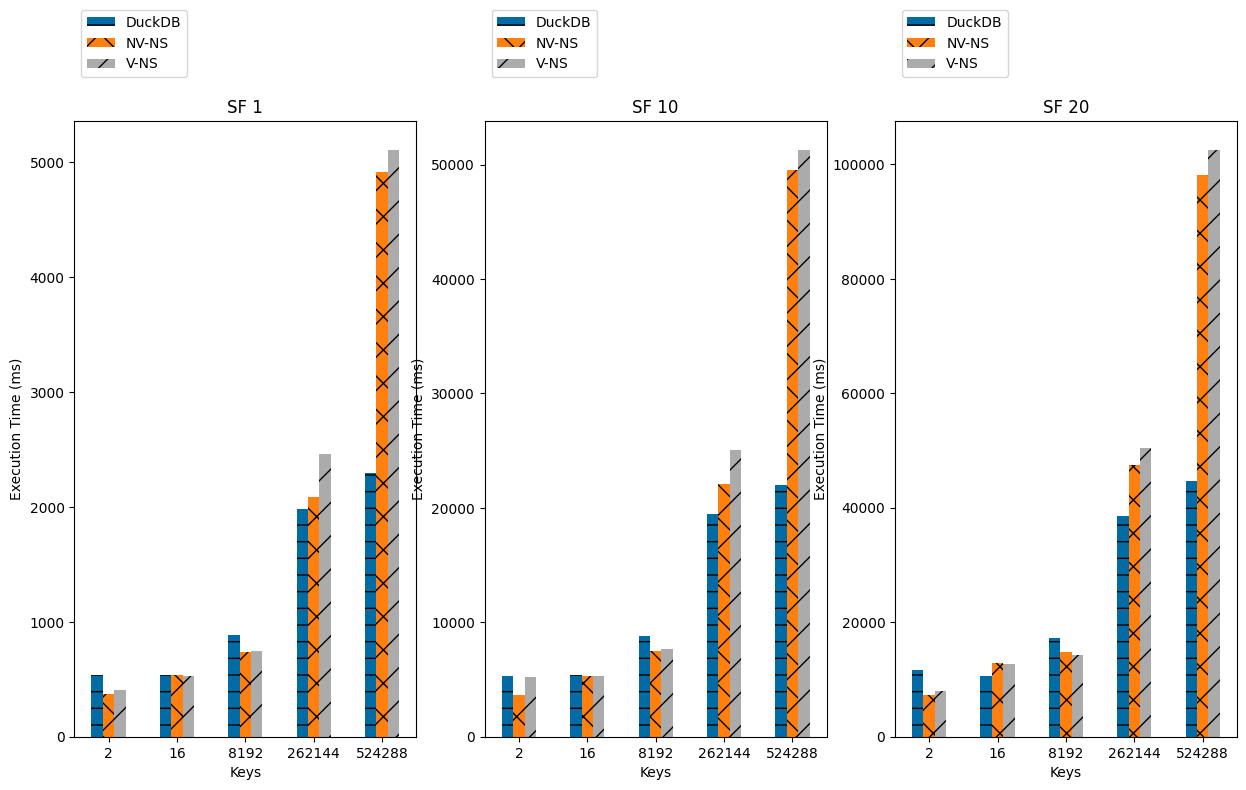

In [8]:
index_column = "Keys"
scale_factors = [1, 10, 20]

fig, ax = plt.subplots(nrows=1, ncols=len(scale_factors), figsize=(15,8))

for i, sf in enumerate(scale_factors):
    duckdb_data = aggregation_query_duck[aggregation_query_duck["Scale-Factor"] == sf].sort_values(index_column)
    index = duckdb_data[index_column]

    aethra_data = aggregation_query[aggregation_query["Scale-Factor"] == sf].sort_values(index_column)
    aethra_nv_ns_data = aethra_data[aethra_data["Engine"] == "NV-NS"]
    aethra_v_ns_data = aethra_data[aethra_data["Engine"] == "V-NS"]

    df = pd.DataFrame({
        'DuckDB': duckdb_data["Running-Time"].tolist(),
        'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
        'V-NS': aethra_v_ns_data["Running-Time"].tolist(),
    }, index = index)

    df.plot.bar(rot=0, ax=ax[i])
    ax[i].set_ylabel("Execution Time (ms)")
    ax[i].set_title("SF " + str(sf))

    bars = ax[i].patches
    hatches = [p for p in plt_patterns for j in range(len(df))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    ax[i].legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

# Analysis of the Join Query at different Scale Factors
For this experiment, we only ran the query at selectivity instance A-B 0.6, A-C 0.8

In [9]:
# Get the data of the join query
join_query = aethra_results[aethra_results['Benchmark'].str.contains('join_query')].copy(deep=True)

# Introduce the "Engine" column
join_query["Engine"] = join_query.apply(
    lambda x: "NV-NS" if 'NonVectorisedNonSimd' in x['Benchmark']
    else ("NV-S" if 'NonVectorisedSimd' in x['Benchmark']
          else ("V-NS" if 'VectorisedNonSimd' in x['Benchmark']
                else "V-S")), axis=1)

# No need to get the selectivity of each join, since the experiment was only run at A-B 0.6, A-C 0.8

# Introduce the hard-coded column
join_query['BenchmarkStyle'] = join_query.apply(
    lambda x: "Hard-coded" if 'hard_coded' in x['Benchmark'] and 'Optimised' not in x['Benchmark']
    else ("Hard-coded-optimised" if 'hard_coded' in x['Benchmark'] and 'Optimised' in x['Benchmark']
          else "Standard"), axis=1)

# Drop irrelevant columns
join_query.drop(columns=["Benchmark", "Param: tableFilePath", "Param: tpchInstance"], inplace=True)

join_query.head()

,Running-Time,Scale-Factor,Engine,BenchmarkStyle
432,5170.3,1,NV-NS,Standard
441,58290.8,10,NV-NS,Standard
450,5385.5,1,V-NS,Standard
459,57525.7,10,V-NS,Standard
468,2310.8,1,NV-NS,Hard-coded


In [10]:
# Load duckdb reference data
join_query_duck = pd.read_csv("duckdb_join_query_result_R440.csv")
join_query_duck.head()

,Running-Time,Scale-Factor,Engine,BenchmarkStyle
0,675.9,1,DuckDB,Standard
1,675.9,1,DuckDB,Hard-coded
2,675.9,1,DuckDB,Hard-coded-optimised
3,8007.0,10,DuckDB,Standard
4,8007.0,10,DuckDB,Hard-coded


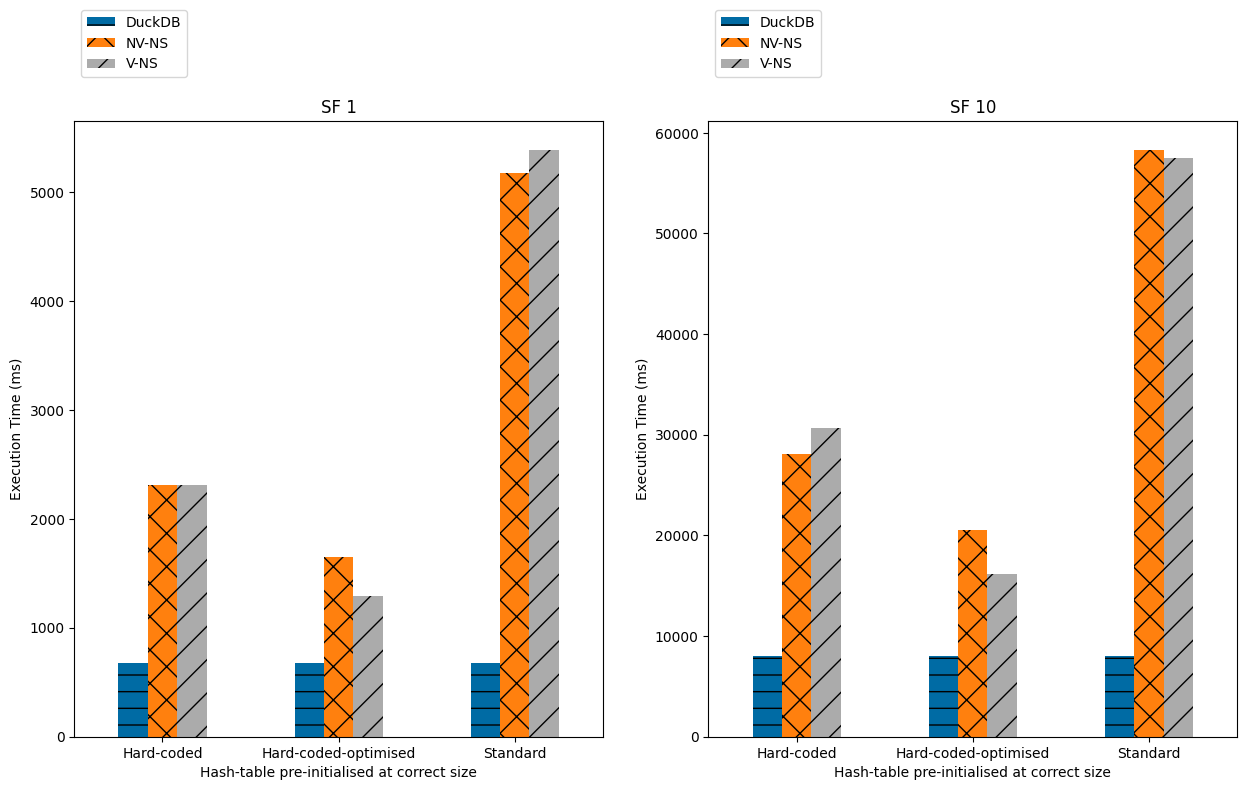

In [11]:
index_column = "BenchmarkStyle"
scale_factors = [1, 10]

fig, ax = plt.subplots(nrows=1, ncols=len(scale_factors), figsize=(15,8))

for i, sf in enumerate(scale_factors):
    duckdb_data = join_query_duck[join_query_duck["Scale-Factor"] == sf].sort_values(index_column)
    index = duckdb_data[index_column]

    aethra_data = join_query[join_query["Scale-Factor"] == sf].sort_values(index_column)
    aethra_nv_ns_data = aethra_data[aethra_data["Engine"] == "NV-NS"]
    aethra_v_ns_data = aethra_data[aethra_data["Engine"] == "V-NS"]

    df = pd.DataFrame({
        'DuckDB': duckdb_data["Running-Time"].tolist(),
        'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
        'V-NS': aethra_v_ns_data["Running-Time"].tolist()
    }, index = index)

    df.plot.bar(rot=0, ax=ax[i])
    ax[i].set_ylabel("Execution Time (ms)")
    ax[i].set_xlabel("Hash-table pre-initialised at correct size")
    ax[i].set_title("SF " + str(sf))

    bars = ax[i].patches
    hatches = [p for p in plt_patterns for j in range(len(df))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    ax[i].legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

# Analysis of TPC-H Q1 at different Scale Factors

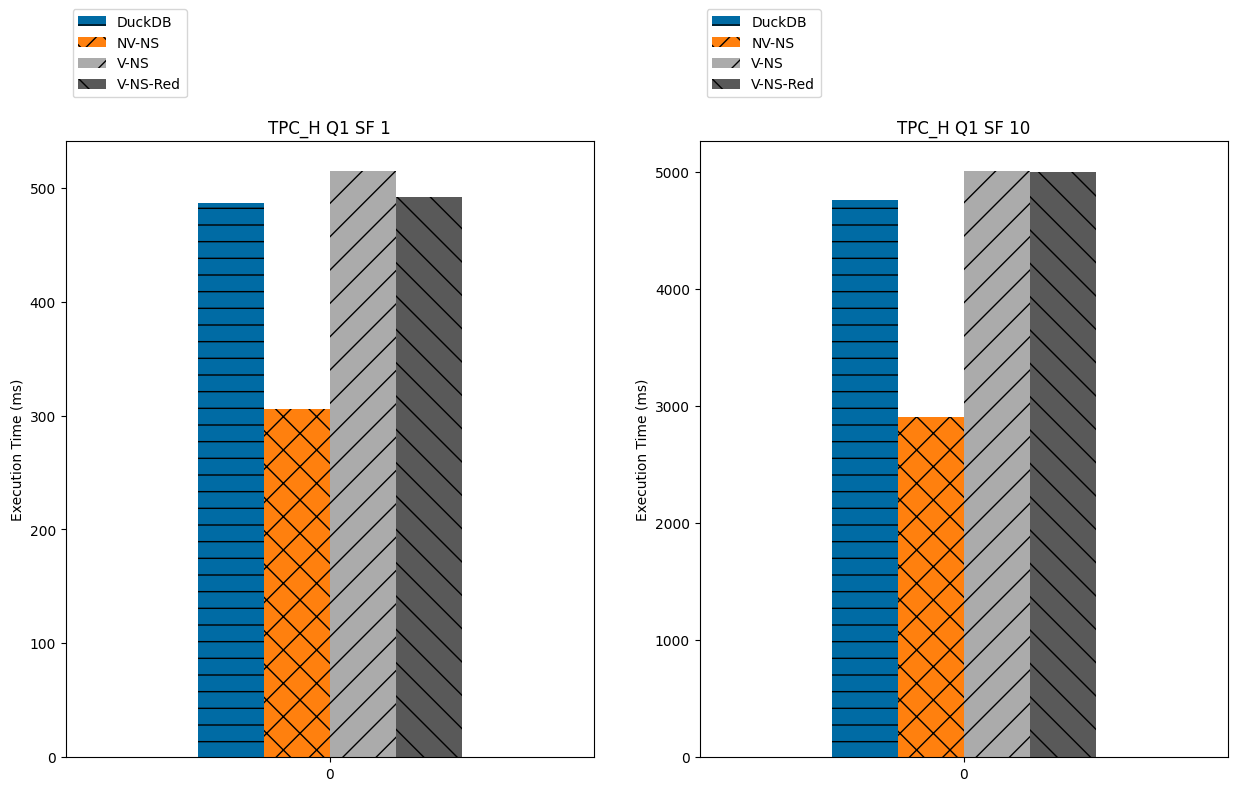

In [12]:
def plot_tpch_data(query_number):
    # Get the data of the query
    tpch_data = aethra_results[aethra_results['Benchmark'].str.contains('tpch')].copy(deep=True)
    tpch_query_data = tpch_data[tpch_data['Benchmark'].str.contains('q' + str(query_number) + '_')].copy(deep=True)

    # Introduce the "Engine" column
    tpch_query_data["Engine"] = tpch_query_data.apply(
        lambda x: "NV-NS" if 'NonVectorisedNonSimd' in x['Benchmark']
            else ("NV-S" if 'NonVectorisedSimd' in x['Benchmark']
                  else ("V-NS" if 'VectorisedNonSimd' in x['Benchmark'] and "Red" not in x['Benchmark']
                        else ("V-NS-Red" if 'VectorisedNonSimd' in x['Benchmark']
                              else ("V-S" if 'VectorisedSimd' in x['Benchmark'] and "Red" not in x['Benchmark']
                                   else "V-S-Red")))), axis=1)

    # Drop irrelevant columns
    tpch_query_data.drop(columns=["Benchmark", "Param: tableFilePath", "Param: tpchInstance"], inplace=True)
    
    # Load duckdb reference data
    tpch_query_duck = pd.read_csv("duckdb_tpch_q" + str(query_number) + "_query_result_R440.csv")
    
    # Obtain the different scale factors
    sf_vals = tpch_query_data["Scale-Factor"].unique()
    sf_vals.sort()
    scale_factors = list(sf_vals)

    # Plot the data
    fig, ax = plt.subplots(nrows=1, ncols=len(scale_factors), figsize=(15,8))

    for i, sf in enumerate(scale_factors):
        duckdb_data = tpch_query_duck[tpch_query_duck["Scale-Factor"] == sf]

        aethra_data = tpch_query_data[tpch_query_data["Scale-Factor"] == sf]
        aethra_nv_ns_data = aethra_data[aethra_data["Engine"] == "NV-NS"]
        aethra_v_ns_data = aethra_data[aethra_data["Engine"] == "V-NS"]
        aethra_v_ns_red_data = aethra_data[aethra_data["Engine"] == "V-NS-Red"]

        df = pd.DataFrame({
            'DuckDB': duckdb_data["Running-Time"].tolist(),
            'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
            'V-NS': aethra_v_ns_data["Running-Time"].tolist(),
            'V-NS-Red': aethra_v_ns_red_data["Running-Time"].tolist(),
        })

        df.plot.bar(rot=0, ax=ax[i])
        ax[i].set_ylabel("Execution Time (ms)")
        ax[i].set_title("TPC_H Q" + str(query_number) + " SF " + str(sf))

        bars = ax[i].patches
        hatches = [p for p in plt_patterns for j in range(len(df))]
        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)

        ax[i].legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))
    

plot_tpch_data(1)

# Analysis of TPC-H Q3 at different Scale Factors

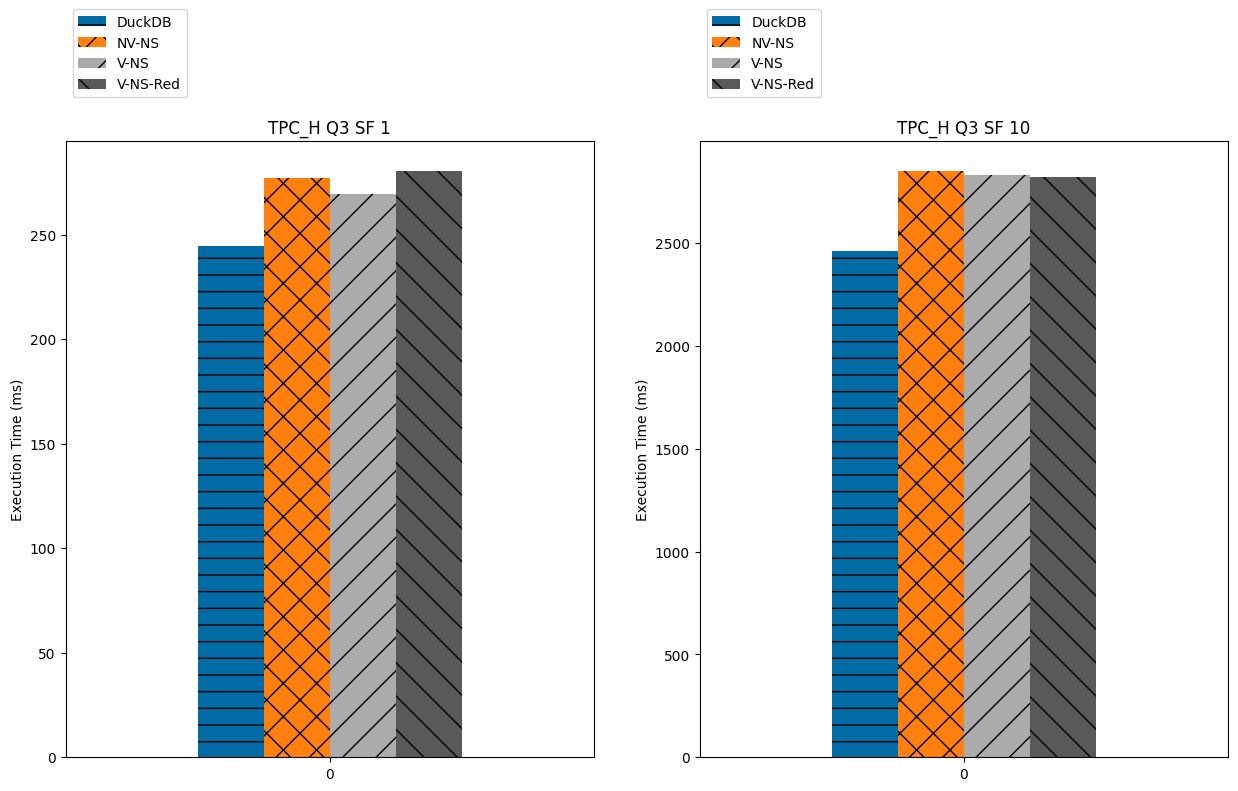

In [13]:
plot_tpch_data(3)

# Analysis of TPC-H Q6 at different Scale Factors

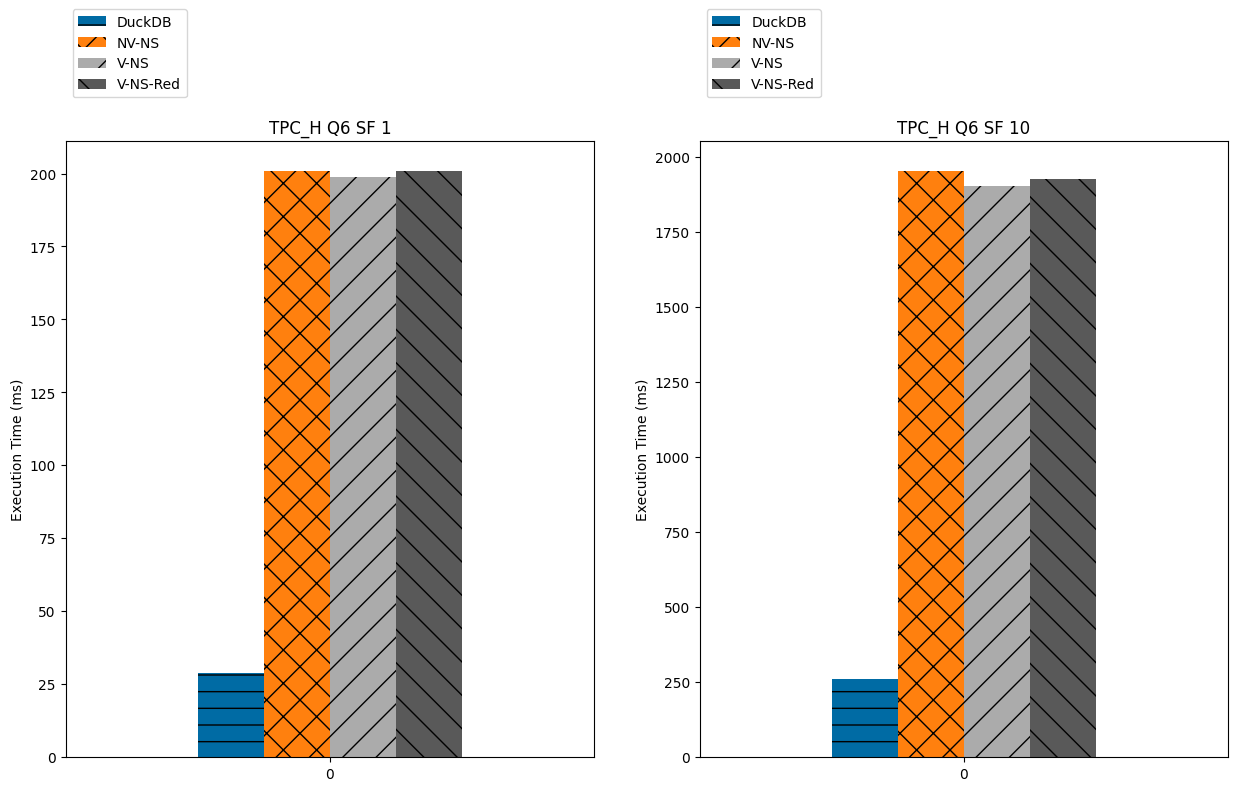

In [14]:
plot_tpch_data(6)

# Analysis of TPC-H Q10 at different Scale Factors

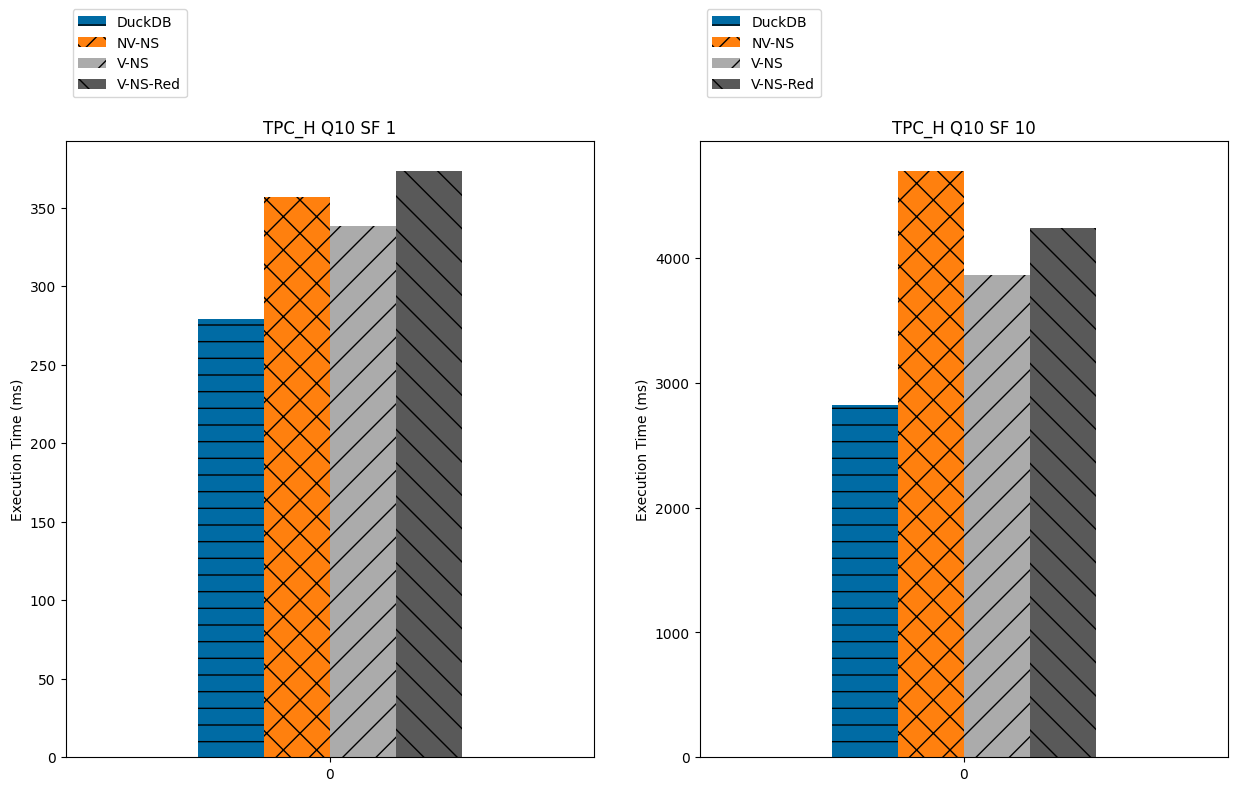

In [15]:
plot_tpch_data(10)